In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2
from tqdm import tqdm


from matplotlib.pyplot import imshow
import math
import json
import re
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [67]:
# Configuration
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "best_VGG_model_1.pth"  # Update with your model path

In [57]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()
        self.vgg16 = models.vgg16(pretrained=pretrained)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.vgg16(x)

In [58]:
class OcclusionSensitivity:
    def __init__(self, model, window_size=32, stride=16):
        self.model = model
        self.window_size = window_size
        self.stride = stride
        
    def generate_heatmap(self, input_tensor, target_class=None):
        """Generate occlusion sensitivity heatmap"""
        with torch.no_grad():
            # Original prediction
            original_output = torch.sigmoid(self.model(input_tensor))
            original_prob = original_output.item()
            original_class = 1 if original_prob > 0.5 else 0
            target_class = target_class or original_class
            
            # Setup dimensions
            b, c, h, w = input_tensor.shape
            heatmap = torch.zeros((h, w), device=DEVICE)
            pad = self.window_size // 2
            
            # Pad input for complete coverage
            padded_input = F.pad(input_tensor, (pad, pad, pad, pad), value=0)
            
            # Slide occlusion window
            for y in tqdm(range(0, h, self.stride), desc="Generating occlusion map"):
                for x in range(0, w, self.stride):
                    # Create occluded version
                    occluded = padded_input.clone()
                    y_start = y + pad
                    x_start = x + pad
                    occluded[..., y_start:y_start+self.window_size, 
                            x_start:x_start+self.window_size] = 0
                    
                    # Get modified prediction
                    output = torch.sigmoid(self.model(occluded[..., pad:-pad, pad:-pad]))
                    current_prob = output.item()
                    
                    # Calculate impact score
                    if target_class == 1:
                        score = original_prob - current_prob
                    else:
                        score = current_prob - original_prob
                    
                    # Update heatmap
                    y_end = min(y + self.stride, h)
                    x_end = min(x + self.stride, w)
                    heatmap[y:y_end, x:x_end] += score
            
            # Normalize and return
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            return heatmap.cpu().numpy()

In [59]:
def load_model(model_path, device):
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    return model

In [60]:
def visualize_occlusion(model, image_path, transform, window_size=32, stride=16):
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    # Generate heatmap
    occlude = OcclusionSensitivity(model, window_size=window_size, stride=stride)
    heatmap = occlude.generate_heatmap(input_tensor)
    
    # Process visualizations
    image_np = np.array(image)
    heatmap = cv2.resize(heatmap, image.size)
    
    # Create heatmap overlay
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Blend with original image
    blended = cv2.addWeighted(image_np, 0.7, heatmap_colored, 0.3, 0)
    
    return image, heatmap, heatmap_colored, blended

In [61]:
def visualize_multiple_occlusion(model, image_paths, transform, num_images=5, figsize=(20, 15), window_size=32, stride=16):
    results = []
    for img_path in image_paths[:num_images]:
        results.append(visualize_occlusion(model, img_path, transform, window_size, stride=16))
    
    # Plot results
    fig, axes = plt.subplots(num_images, 4, figsize=figsize)
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    for idx, (image, heatmap, heatmap_colored, blended) in enumerate(results):
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f"Original {idx+1}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(heatmap, cmap='inferno')
        axes[idx, 1].set_title(f"Heatmap {idx+1}")
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(heatmap_colored)
        axes[idx, 2].set_title(f"Color Map {idx+1}")
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(blended)
        axes[idx, 3].set_title(f"Blended {idx+1}")
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    return results

In [62]:
# # Example Usage
# if __name__ == "__main__":
#     # Load model
#     model = load_model(MODEL_PATH, DEVICE)
    
#     # Define transforms
#     transform = transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
    
#     # Get sample images
#     sample_images = [
#         "image1.jpg",
#         # "image2.jpg",
#         # "image3.jpg",
#         # "image4.jpg",
#         # "image5.jpg"
#         # Add your image paths here
#     ]
    
#     # Generate visualizations
#     results = visualize_multiple_occlusion(
#         model=model,
#         image_paths=sample_images,
#         transform=transform,
#         num_images=5,
#         window_size=40,  # Adjust based on your image features
#         stride=20
#     )

In [63]:
# Process a directory of B-scans with occlusion sensitivity
def process_bscans_with_occlusion(model, bscan_dir, output_dir, transform, window_size=32, stride=16):
    """
    Process all B-scan images in a directory with occlusion sensitivity and save results
    
    Args:
        model: The trained model
        bscan_dir: Directory containing B-scan images
        output_dir: Directory to save occlusion heatmaps
        transform: Image transformation for model input
        window_size: Size of occlusion window
        stride: Stride for occlusion analysis
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create occlusion sensitivity analyzer
    occluder = OcclusionSensitivity(model, window_size=window_size, stride=stride)
    
    # Get list of images
    img_filenames = sorted([
        f for f in os.listdir(bscan_dir)
        if f.endswith((".png", ".jpg", ".jpeg"))
    ])
    
    for img_name in tqdm(img_filenames, desc="Processing B-scans"):
        img_path = os.path.join(bscan_dir, img_name)
        
        # Load and process image
        image = Image.open(img_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = occluder.generate_heatmap(input_tensor)
        
        # Process visualizations
        image_np = np.array(image)
        heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
        
        # Create heatmap overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_INFERNO)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Blend with original image
        blended = cv2.addWeighted(image_np, 0.7, heatmap_colored, 0.3, 0)
        
        # Save results
        output_path = os.path.join(output_dir, img_name)
        cv2.imwrite(output_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))
        
        # Save raw heatmap for further processing
        heatmap_path = os.path.join(output_dir, f"heatmap_{img_name}")
        cv2.imwrite(heatmap_path, np.uint8(255 * heatmap_resized))
    
    print(f"✅ Processed {len(img_filenames)} B-scans with occlusion sensitivity")

In [75]:
# Generate fovea probability map from occlusion heatmaps
def generate_occlusion_fovea_map(enface_path, occlusions_dir, num_slices=128):
    """
    Generate a fovea probability map from occlusion sensitivity heatmaps
    
    Args:
        enface_path: Path to the enface image
        occlusions_dir: Directory containing occlusion heatmap images
        num_slices: Number of B-scan slices (default=128)
        
    Returns:
        enface_img: Original enface image
        prob_map: Generated probability map
    """
    # Load enface image
    enface_img = cv2.imread(enface_path)
    enface_img = cv2.resize(enface_img, (512, 512))
    
    # Initialize heatmap canvas
    prob_map = np.zeros((512, 512), dtype=np.float32)
    y_positions = []
    
    # Read occlusion heatmap files
    img_filenames = sorted([
        f for f in os.listdir(occlusions_dir)
        if f.startswith("1002") and f.endswith((".png", ".jpg", ".jpeg"))
    ])
    
    for img_name in img_filenames:
        img_path = os.path.join(occlusions_dir, img_name)
        heatmap_img = cv2.imread(img_path)
        # heatmap_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if heatmap_img is None:
            continue
            
        # Extract index from filename
        match = re.search(r'bscan_(\d+)', img_name)
        if not match:
            continue
            
        idx = int(match.group(1))
        y_pos = int((idx / num_slices) * 512)
        y_positions.append(y_pos)
        
        # Resize and potentially roll (adjust shift if needed)
        heatmap_img = cv2.resize(heatmap_img, (512, 512))
        heatmap_img = np.roll(heatmap_img, shift=-4, axis=1)  # Same as ScoreCam implementation
        
        # Collapse vertically to horizontal profile
        profile = np.sum(heatmap_img, axis=0).astype(np.float32)
        profile = gaussian_filter1d(profile, sigma=2)  # Smooth profile
        if profile.max() > 0:
            profile /= profile.max()  # Normalize
            
        # Add profile to map at y_pos
        prob_map[y_pos, :] = profile
    
    # Fill above & below missing lines with 0
    if y_positions:
        y_min, y_max = min(y_positions), max(y_positions)
        for y in range(0, y_min):
            prob_map[y, :] = 0.0
        for y in range(y_max + 1, 512):
            prob_map[y, :] = 0.0
    
    # Smooth vertically
    prob_map = gaussian_filter(prob_map, sigma=(1.5, 1.5))
    prob_map /= prob_map.max() + 1e-6  # Normalize
    
    return enface_img, prob_map

In [76]:
# Visualize the generated occlusion fovea map
def visualize_occlusion_fovea_map(enface_img, prob_map, output_path=None):
    """
    Visualize the generated occlusion fovea map
    
    Args:
        enface_img: Original enface image
        prob_map: Generated probability map
        output_path: Path to save the visualization (optional)
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(enface_img, cmap='gray')
    heat = plt.imshow(prob_map, cmap='jet', alpha=0.5)
    cbar = plt.colorbar(heat, fraction=0.046, pad=0.04)
    cbar.set_label("Fovea Probability", fontsize=12)
    cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
    plt.axis("off")
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved visualization to {output_path}")
    
    plt.show()

In [81]:
# Main function to execute the pipeline
def main():
    # Configuration
    model_path = "best_VGG_model_1.pth"
    bscan_dir = "BScan"  # Directory containing B-scan images
    occlusions_output_dir = "img_masked_img"  # Directory to save occlusion heatmaps
    enface_path = "enface.jpg"  # Path to the enface image
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load model
    model = load_model(model_path, device)
    
    # # Process B-scans with occlusion sensitivity
    # process_bscans_with_occlusion(
    #     model=model,
    #     bscan_dir=bscan_dir,
    #     output_dir=occlusions_output_dir,
    #     transform=transform,
    #     window_size=32,
    #     stride=16
    # )
    
    # Generate and visualize fovea map
    enface_img, prob_map = generate_occlusion_fovea_map(
        enface_path=enface_path,
        occlusions_dir=occlusions_output_dir
    )
    
    # Visualize and save the result
    visualize_occlusion_fovea_map(
        enface_img=enface_img,
        prob_map=prob_map,
        output_path="Occlusions_fovea_probability_map.png"
    )

/var/folders/xw/pr4fd47s1y50xqg4b8qxdsk80000gn/T/ipykernel_62465/1512286004.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

✅ Saved visualization to Occlusions_fovea_probability_map.png


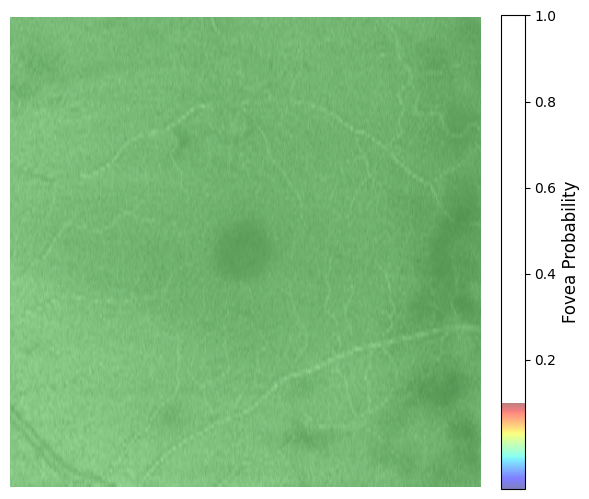

In [82]:
if __name__ == "__main__":
    main()

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.interpolate import griddata
from tqdm import tqdm

def map_bscan_heatmaps_to_enface(bscan_heatmaps, enface_image, pattern_type='foveal', 
                                 num_scans=None, smooth_factor=5, threshold=0.7):
    """
    Map B-scan heatmaps onto an enface image with thresholding to isolate bright regions
    
    Args:
        bscan_heatmaps: List of numpy arrays containing heatmaps from OCT B-scans
        enface_image: Numpy array of the enface image
        pattern_type: The scan pattern - 'foveal', 'raster', or 'radial'
        num_scans: Number of B-scans (if None, uses len(bscan_heatmaps))
        smooth_factor: Size of Gaussian kernel for final smoothing
        threshold: Value (0-1) to threshold the heatmap, only keeping values above this
        
    Returns:
        The enface image with overlaid heatmap (only bright regions)
    """
    # Make sure enface is RGB
    if len(enface_image.shape) == 2:
        enface_rgb = cv2.cvtColor(enface_image, cv2.COLOR_GRAY2RGB)
    else:
        enface_rgb = enface_image.copy()
    
    h, w = enface_rgb.shape[:2]
    
    # If num_scans not provided, use length of heatmaps
    if num_scans is None:
        num_scans = len(bscan_heatmaps)
    
    # Initialize points and values for interpolation
    points = []
    values = []
    
    # Generate scan coordinates based on pattern type
    if pattern_type == 'foveal':
        # Foveal scan pattern (all B-scans pass through center/fovea)
        center_x, center_y = w // 2, h // 2
        
        # Distribute angles evenly
        angles = np.linspace(0, np.pi, num_scans)  # 180 degrees coverage
        
        for i, angle in enumerate(angles):
            if i >= len(bscan_heatmaps):
                break
                
            heatmap = bscan_heatmaps[i]
            
            # Calculate line endpoints (line passing through center)
            radius = min(w, h) // 2 - 5  # Slight margin from edge
            
            # Both ends of the line (passing through center)
            x1 = int(center_x + radius * np.cos(angle))
            y1 = int(center_y + radius * np.sin(angle))
            x2 = int(center_x - radius * np.cos(angle))
            y2 = int(center_y - radius * np.sin(angle))
            
            # Create the line
            line_mask = np.zeros((h, w), dtype=np.uint8)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 1)
            line_y, line_x = np.where(line_mask > 0)
            
            # Skip if no points
            if len(line_x) == 0:
                continue
                
            # Resize heatmap to match line length
            num_points = len(line_x)
            resized_heatmap = cv2.resize(heatmap, (1, num_points), interpolation=cv2.INTER_LINEAR)
            
            # Add points and values
            for j, (x, y) in enumerate(zip(line_x, line_y)):
                if resized_heatmap[j, 0] > 0.05:  # Threshold for computation efficiency
                    points.append([x, y])
                    values.append(resized_heatmap[j, 0])
    
    # Add other pattern types as needed (raster, radial, etc.)
    
    # Create grid for interpolation
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Check if we have enough points for interpolation
    if len(points) < 4:
        print("Warning: Not enough points for interpolation. Check your heatmaps.")
        return enface_rgb
    
    # Convert to numpy arrays
    points = np.array(points)
    values = np.array(values)
    
    # Interpolate values onto the grid
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)
    
    # Smooth the result
    if smooth_factor > 0:
        grid_z = cv2.GaussianBlur(grid_z, (smooth_factor, smooth_factor), 0)
    
    # Normalize the heatmap
    grid_z = (grid_z - grid_z.min()) / (grid_z.max() - grid_z.min() + 1e-8)
    
    # Apply threshold to keep only bright regions
    grid_z[grid_z < threshold] = 0
    
    # Optional: Renormalize after thresholding for better contrast
    if np.max(grid_z) > 0:  # Check to avoid division by zero
        grid_z = (grid_z - grid_z.min()) / (grid_z.max() - grid_z.min() + 1e-8)
    
    # Apply colormap to create colored heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * grid_z), cv2.COLORMAP_HOT)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Create a mask for overlay (alpha channel)
    alpha_mask = (grid_z > 0).astype(np.float32)
    alpha_mask = cv2.GaussianBlur(alpha_mask, (5, 5), 0)  # Smooth the edges
    
    # Create result image
    result = enface_rgb.copy()
    
    # Only blend where the mask is non-zero
    for c in range(3):  # RGB channels
        result[:,:,c] = enface_rgb[:,:,c] * (1 - alpha_mask) + heatmap_colored[:,:,c] * alpha_mask
    
    return result

def process_enface_heatmap_with_threshold(heatmap_dir, enface_path, output_path=None, 
                                         pattern_type='foveal', smooth_factor=5, threshold=0.7):
    """
    Process enface image with thresholded heatmap overlay
    
    Args:
        heatmap_dir: Directory containing heatmap images
        enface_path: Path to the enface image
        output_path: Path to save the result (optional)
        pattern_type: Scan pattern type ('foveal', 'raster', 'radial')
        smooth_factor: Size of Gaussian blur kernel for smoothing
        threshold: Value (0-1) to threshold the heatmap, only showing bright regions
        
    Returns:
        The resulting enface image with overlaid thresholded heatmap
    """
    # Load heatmaps
    heatmap_files = sorted([f for f in os.listdir(heatmap_dir) 
                          if f.startswith('heatmap_') or f.endswith('.png') or f.endswith('.jpg')])
    
    bscan_heatmaps = []
    for heatmap_file in tqdm(heatmap_files, desc="Loading heatmaps"):
        path = os.path.join(heatmap_dir, heatmap_file)
        heatmap = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if heatmap is None:
            print(f"Warning: Could not load {path}")
            continue
            
        # Normalize
        heatmap = heatmap.astype(np.float32) / 255.0
        bscan_heatmaps.append(heatmap)
    
    print(f"Loaded {len(bscan_heatmaps)} heatmap images")
    
    if len(bscan_heatmaps) == 0:
        print("No heatmaps found. Check your directory.")
        return None
    
    # Load enface image
    enface_image = cv2.imread(enface_path)
    if enface_image is None:
        print(f"Could not load enface image: {enface_path}")
        return None
        
    enface_image = cv2.cvtColor(enface_image, cv2.COLOR_BGR2RGB)
    
    # Map heatmaps to enface with threshold
    result = map_bscan_heatmaps_to_enface(
        bscan_heatmaps, 
        enface_image, 
        pattern_type=pattern_type, 
        smooth_factor=smooth_factor,
        threshold=threshold
    )
    
    # Save if output path provided
    if output_path:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # Make sure the file has a valid extension
        valid_extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
        file_ext = os.path.splitext(output_path)[1].lower()
        
        if file_ext not in valid_extensions:
            # Default to PNG if extension is invalid
            output_path = output_path + '.png'
            print(f"Added .png extension to output path: {output_path}")
            
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        print(f"Saved result to: {output_path}")
    
    return result

Loading heatmaps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.88it/s]


Loaded 2 heatmap images


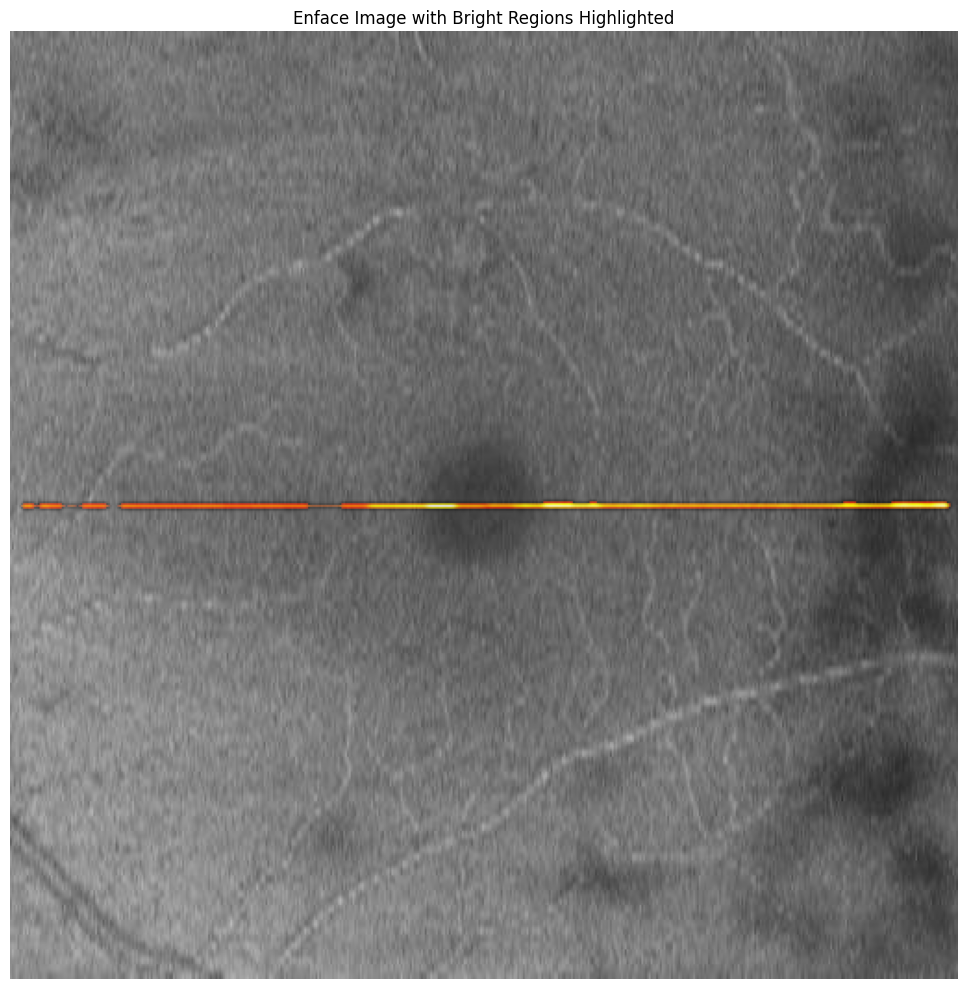

In [106]:
# Example usage
if __name__ == "__main__":
    # Example configuration
    heatmap_dir = "img_masked_img"  # Directory with your heatmap images
    enface_path = "enface.jpg"  # Path to your enface image
    output_path = ""  # Where to save the result
    
    # Process with thresholding to show only bright regions
    result = process_enface_heatmap_with_threshold(
        heatmap_dir=heatmap_dir,
        enface_path=enface_path,
        output_path=output_path,
        pattern_type='foveal',
        smooth_factor=7,
        threshold=0.45  # Adjust this value to control how much is shown (0.0-1.0)
    )
    
    # Display result
    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('Enface Image with Bright Regions Highlighted')
    plt.tight_layout()
    plt.show()